# Do the feature engineering according to the selection done in the exploratory data analysis and run a linear regression

In [1]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
from statsmodels import stats as st

import seaborn as sns

import scipy.stats as stats

from matplotlib import pyplot as plt

import numpy as np

In [33]:
df = pd.read_csv('day.csv', index_col=0)
df.head()
df.casual.describe()

3292679

In [3]:
df['dteday'] = pd.to_datetime(df['dteday'])
df['dteday'].head()

instant
1   2011-01-01
2   2011-01-02
3   2011-01-03
4   2011-01-04
5   2011-01-05
Name: dteday, dtype: datetime64[ns]

#### Feature Engineering Function:

In [4]:
#weather = {1: 'nice_weather', 2: 'so_so_weather', 3: 'shit_weather'}
#weather_dummies = pd.get_dummies(df['weathersit'])
#weather_dummies = weather_dummies.drop(weather_dummies.columns[0], axis=1)
#weather_dummies.rename(mapper=weather, axis=1, inplace=True)
#x = pd.concat([x, weather_dummies], axis=1)
#x = x.drop('weathersit', axis=1)

#weather_dummies.head()

In [5]:
#df.loc[:, 'atemp2'] = pd.Series(np.array(df['atemp'])**2)
#df.atemp2

In [6]:
def feature_engineer(x):
    x = x[['yr',
           'mnth',
           'holiday',
           'weekday',
           'workingday',
           'weathersit',
           #'temp',
           'atemp',
           'hum', #is highly insignificant
           'windspeed'
           ]]
    
    if 'mnth' in x:
        # create dummies for months; Feb is not significantly different from 0 and is therefore excluded
        months = {2: 'Feb',3: 'March',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'}
        mnth_dummies = pd.get_dummies(x['mnth'])
        mnth_dummies = mnth_dummies.drop([mnth_dummies.columns[0], mnth_dummies.columns[1], mnth_dummies.columns[5], mnth_dummies.columns[10]], axis=1)
        mnth_dummies.rename(mapper=months, axis=1, inplace=True)
        x = pd.concat([x, mnth_dummies], axis=1)
        x = x.drop('mnth', axis=1)
        
    if 'weekday' in x:
        # create dummies for the weekdays; it turns out that only saturdays yields a statistically significant result
        days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
        wday_dummies = pd.get_dummies(x['weekday'])
        wday_dummies = wday_dummies.drop(wday_dummies.columns[0], axis=1)
        wday_dummies.rename(mapper=days, axis=1, inplace=True)
        x = pd.concat([x, pd.DataFrame(wday_dummies['Sat'])], axis=1)
        #x = pd.concat([x, wday_dummies], axis=1)
        x = x.drop('weekday', axis=1)
        
    if 'weathersit' in x:
        weather = {1: 'nice_weather', 2: 'so_so_weather', 3: 'shit_weather'}
        weather_dummies = pd.get_dummies(x['weathersit'])
        weather_dummies = weather_dummies.drop(weather_dummies.columns[0], axis=1)
        weather_dummies.rename(mapper=weather, axis=1, inplace=True)
        x = pd.concat([x, weather_dummies], axis=1)
        x = x.drop('weathersit', axis=1)
        
    #if 'atemp' in x:
    #    x.loc[:, 'atemp2'] = x['atemp']**2
    #    x = x.drop('atemp', axis=1)
        
    
    return x

#### Split the data:

In [7]:
# split the data into input and output variables
X = df.drop('cnt', axis=1)
y = df['cnt']
casual = df['casual']
registered = df['registered'] 

# split the data into training and test data for casual
Xtrain, Xtest, ctrain, ctest = train_test_split(X, casual, random_state=42)

# split the data into training and test data for casual
Xtrain, Xtest, rtrain, rtest = train_test_split(X, registered, random_state=42)

# split the data into training and test data for casual
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)

#### Feature Engineering:

In [8]:
Xtrain = feature_engineer(Xtrain)
Xtest = feature_engineer(Xtest)
Xtrain.head()

,yr,holiday,workingday,atemp,hum,windspeed,March,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Sat,so_so_weather,shit_weather
instant,,,,,,,,,,,,,,,,,,,
689,1,0,1,0.375621,0.623333,0.235067,0,0,0,0,0,0,0,0,1,0,0,1,0
650,1,0,1,0.431167,0.463333,0.181596,0,0,0,0,0,0,0,1,0,0,0,0,0
638,1,0,0,0.530296,0.542917,0.227604,0,0,0,0,0,0,1,0,0,0,1,0,0
526,1,0,0,0.648367,0.437083,0.144287,0,0,0,1,0,0,0,0,0,0,1,0,0
368,1,0,1,0.126275,0.441250,0.365671,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
#corr = Xtrain.corr()
#corr

#### Fit the model:

In [10]:
mc = LinearRegression()
mr = LinearRegression()

In [11]:
mc.fit(Xtrain, ctrain)
mc.coef_, mc.intercept_

(array([  286.89289608,  -250.55500772,  -751.46213591,  1876.73873931,
         -553.98254448, -1016.50072192,   439.5366176 ,   500.82808055,
          519.01401461,   367.28544834,   150.9058375 ,   233.24436723,
          455.7097097 ,   454.76715928,   245.30178016,    73.58377578,
          194.94777735,  -137.03628561,  -372.9238122 ]), 613.2339008466873)

In [12]:
mr.fit(Xtrain, rtrain)
mr.coef_, mr.intercept_

(array([ 1696.45718969,  -184.24332377,  1133.82846607,  3828.8567974 ,
         -955.42483905, -1628.37607853,   429.24474898,   642.10874039,
          856.80960352,   775.39206737,   270.89320343,   591.94240329,
         1347.88881528,  1481.06464415,  1096.6440214 ,   741.87112439,
          281.26948811,  -369.70796918, -1357.16620588]), 562.1103299420847)

#### Evaluate the model:

In [13]:
# let's have a look at the R2 of the model
round(mc.score(Xtrain, ctrain), 2)

0.74

In [14]:
cross_val_score(mc, Xtrain, ctrain, cv=5).mean()

0.7077877131424731

In [15]:
# let's have a lookt at the R2 of the model using the test data
round(mc.score(Xtest, ctest), 2)

0.67

In [16]:
round(mr.score(Xtrain, rtrain), 2)

0.82

In [17]:
cross_val_score(mc, Xtrain, rtrain, cv=5).mean()

0.7941658172477997

In [18]:
round(mr.score(Xtest, rtest), 2)

0.82

#### Use statsmodels to output some statistics on the regression results

In [19]:
# Fit and summarize OLS model
modc = sm.OLS(ctrain, sm.add_constant(Xtrain))

resc = modc.fit()

resc.summary()

/Users/stefanroth/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     78.58
Date:                Fri, 14 Jun 2019   Prob (F-statistic):          3.71e-140
Time:                        15:03:32   Log-Likelihood:                -4009.5
No. Observations:                 548   AIC:                             8059.
Df Residuals:                     528   BIC:                             8145.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           613.2339    129.353      4.741      0.000     359.125     867.343
yr              286.8929     32.566      8.809      0.000     222.917     350.869
holiday        -250.5550    107.327     -2.335      0.020    -461.395     -39.715
workingday     -751.4621     44.380    -16.933      0.000    -838.644    -664.280
atemp          1876.7387    241.665      7.766      0.000    1401.995    2351.482
hum            -553.9825    159.041     -3.483      0.001    -866.413    -241.552
windspeed     -1016.5007    227.015     -4.478      0.000   -1462.465    -570.537
March           439.5366     78.170      5.623      0.000     285.974     593.099
Apr             500.8281     82.080      6.102      0.000     339.584     662.072
May             519.0140     93.438      5.555      0.000     335.459     702.569
Jun             367.2854    109.653      3.350      0.001     151.876     582.695
Jul             150.9058    121.948      1.237      0.216     -88.657     390.468
Aug             233.2444    113.864      2.048      0.041       9.562     456.926
Sept            455.7097     98.340      4.634      0.000     262.524     648.895
Oct             454.7672     79.701      5.706      0.000     298.198     611.336
Nov             245.3018     72.677      3.375      0.001     102.531     388.073
Dec              73.5838     70.811      1.039      0.299     -65.523     212.690
Sat             194.9478     56.560      3.447      0.001      83.838     306.058
so_so_weather  -137.0363     43.022     -3.185      0.002    -221.552     -52.521
shit_weather   -372.9238    107.398     -3.472      0.001    -583.904    -161.943
==============================================================================
Omnibus:                       77.287   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.397
Skew:                           0.739   Prob(JB):                     3.34e-41
Kurtosis:                       5.446   Cond. No.                         34.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Fit and summarize OLS model
modr = sm.OLS(rtrain, sm.add_constant(Xtrain))

resc = modr.fit()

resc.summary()

/Users/stefanroth/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             registered   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     128.1
Date:                Fri, 14 Jun 2019   Prob (F-statistic):          1.26e-183
Time:                        15:03:32   Log-Likelihood:                -4325.0
No. Observations:                 548   AIC:                             8690.
Df Residuals:                     528   BIC:                             8776.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           562.1103    230.036      2.444      0.015     110.212    1014.009
yr             1696.4572     57.915     29.292      0.000    1582.685    1810.229
holiday        -184.2433    190.866     -0.965      0.335    -559.193     190.707
workingday     1133.8285     78.923     14.366      0.000     978.787    1288.870
atemp          3828.8568    429.769      8.909      0.000    2984.590    4673.124
hum            -955.4248    282.833     -3.378      0.001   -1511.040    -399.809
windspeed     -1628.3761    403.716     -4.033      0.000   -2421.463    -835.290
March           429.2447    139.015      3.088      0.002     156.155     702.335
Apr             642.1087    145.969      4.399      0.000     355.358     928.859
May             856.8096    166.166      5.156      0.000     530.381    1183.238
Jun             775.3921    195.003      3.976      0.000     392.316    1158.468
Jul             270.8932    216.868      1.249      0.212    -155.136     696.923
Aug             591.9424    202.492      2.923      0.004     194.154     989.731
Sept           1347.8888    174.884      7.707      0.000    1004.334    1691.443
Oct            1481.0646    141.737     10.449      0.000    1202.628    1759.502
Nov            1096.6440    129.246      8.485      0.000     842.745    1350.543
Dec             741.8711    125.928      5.891      0.000     494.489     989.253
Sat             281.2695    100.584      2.796      0.005      83.675     478.864
so_so_weather  -369.7080     76.509     -4.832      0.000    -520.008    -219.408
shit_weather  -1357.1662    190.993     -7.106      0.000   -1732.367    -981.966
==============================================================================
Omnibus:                      142.229   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              409.729
Skew:                          -1.248   Prob(JB):                     1.07e-89
Kurtosis:                       6.422   Cond. No.                         34.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Check that the assumptions of the model hold:

In [32]:
errors = mc.predict(Xtrain) + mr.predict(Xtrain) - ytrain
round(errors.sum(), 20)

1.4188117348e-10

* the sum of errors is roughly zero; the assumption of zero error in expectation holds

In [22]:
stats.shapiro(errors)

(0.9555543065071106, 8.591243168265539e-12)

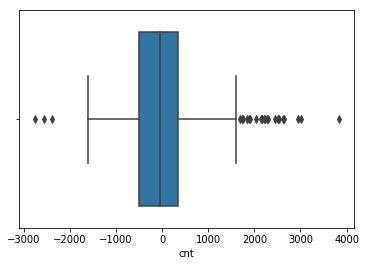

In [23]:
sns.boxplot(errors)

* I think that we can more or less accept the normality of the errors, although the shapiro test strongly leeds us to reject the Null
* Maybe we have to throw out some outliers or actually do some feature engineering

#### Plot a Q-Q plot to "test" for homoskedasticity

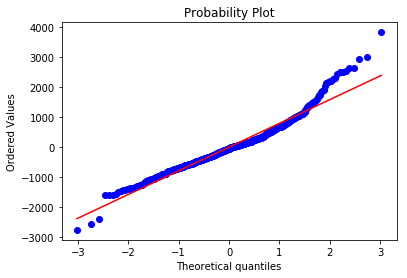

In [24]:
stats.probplot(errors, dist="norm", plot=plt)
plt.show()

(array([  3.,   6.,  60., 178., 190.,  75.,  18.,  11.,   6.,   1.]),
 array([-2769.178125  , -2108.95699566, -1448.73586632,  -788.51473699,
         -128.29360765,   531.92752169,  1192.14865103,  1852.36978036,
         2512.5909097 ,  3172.81203904,  3833.03316838]),
 <a list of 10 Patch objects>)

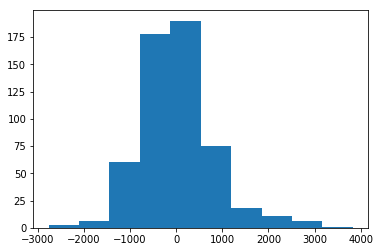

In [25]:
plt.hist(errors)

The errors seem to be quite normal and almost evenly distributed over the whole space except for the fat right tail. What is the cause for these observations?

# Inspect the outliers!!!

In [26]:
inflc = resc.get_influence()
infl = inflc.summary_frame()
infl[np.array(infl.iloc[:, :] > 0.2)].index.unique()
#print(np.array(infl[infl.index == 689])[-1])
#infl.iloc[:, :].sum()

Int64Index([689, 650, 638, 690,  19, 532,  30, 232, 488, 713,
            ...
            344, 309, 662, 664, 100, 459, 122,  21, 701, 107],
           dtype='int64', name='instant', length=263)

<StemContainer object of 3 artists>

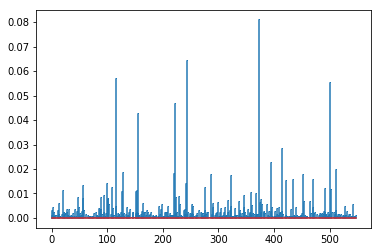

In [27]:
#c is the distance and p is p-value
(c, p) = inflc.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")

In [28]:
# on the 29.09.2012 there was a college football and a baseball match which created a huge outlier (2*mean())
# this observation is accountable for about 11.5% of the coefficient for saturdays
df[df.index == 472]
#df.cnt.sort_values()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
472,2012-04-16,2,1,4,1,1,0,1,0.664167,0.614925,0.561667,0.284829,1198,5172,6370


In [29]:
df[df.index == 204]

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
204,2011-07-23,3,0,7,0,6,0,1,0.849167,0.804287,0.5,0.131221,987,2298,3285


In [30]:
#151, 203, 407]

SyntaxError: invalid syntax (<ipython-input-30-c360b20160cb>, line 1)